In [1]:
using CSV, DataFrames, Plots, Statistics, JuMP, Gurobi, StatsBase

In [2]:
pollution = DataFrame(CSV.File("Data/pollution_location.csv"))
pollution_xy = pollution[:,1:2]|>Matrix
sensors = DataFrame(CSV.File("Data/sensors_location.csv"))
sensors_xy = sensors[:,1:2]|>Matrix;

In [3]:
lat_to_km = [111, 92]
lat_diff = (pollution_xy[:,1].-sensors_xy[:,1]').*lat_to_km[1]
long_diff = (pollution_xy[:,2].-sensors_xy[:,2]').*lat_to_km[2]

dist_matrix = sqrt.(lat_diff.^2 + long_diff.^2)';

In [4]:
r = 2
D = (dist_matrix.<=r)
q = pollution.AIQ
p = 500
n, m = size(dist_matrix)

(2668, 7107)

In [5]:
q = pollution.AIQ
r = 2
p = sum(q)/n  # unit price

111.28863215948053

In [6]:
# q = f(quality)

In [7]:
d = dist_matrix.<=r;

In [8]:
function model1(mu)
    model = Model(Gurobi.Optimizer);
    set_optimizer_attribute(model, "TimeLimit", 5);
    
    @variable(model, x[1:n], Bin) #Whether we put a censor at spot i
    @variable(model, y[1:m].<=1) #Whether we spot j is covered
    
    @constraint(model, y'.<= x'*d)
    # @constraint(model, [i=1:n],x[i]<=sum(d[i])) #censors that do not capture any points are deleted.
    
    
    @objective(model, Max, mu .* sum(y.*q) - (1-mu)*p*sum(x))
    optimize!(model)
    return value.(x), value.(y)
end
x, y = model1(0.2)
sum(y)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-18
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7107 rows, 9775 columns and 26474 nonzeros
Model fingerprint: 0x14424de6
Variable types: 7107 continuous, 2668 integer (2668 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 9e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -32763.37331
Found heuristic solution: objective -0.0000000
Presolve removed 4984 rows and 7060 columns
Presolve time: 0.03s
Presolved: 2123 rows, 2715 columns, 7899 nonzeros
Found heuristic solution: objective 534.0342102
Variable types: 0 continuous, 2715 integer (2715 binary)

Root relaxation: objecti

2072.0

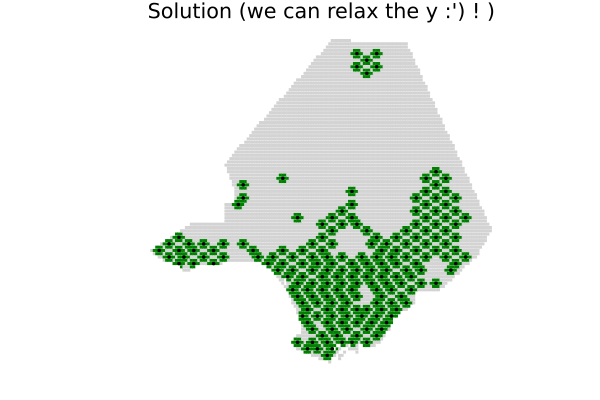

In [9]:
scatter(pollution_xy[:,2], pollution_xy[:,1], marker_z = y, color=cgrad([:lightgray, :green]), markersize = 1.5, 
shape = :rect,  markerstrokewidth = 0,ratio = 1.1,
legend=false, axis=false, grid=false)
title!("Solution (we can relax the y :') ! )")
index_x = findall(x.==1)
scatter!(sensors_xy[index_x,2], sensors_xy[index_x,1], color=:black, markersize = 2,shape = :circle,  markerstrokewidth = 0)

In [10]:
num_sensors = []
num_points = []

for mu in 0:0.1:1
    total_x = sum(model1(mu)[1])
    total_y = sum(model1(mu)[2])
    push!(num_sensors, total_x)
    push!(num_points, total_y)
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-18
Set parameter TimeLimit to value 5
Set parameter TimeLimit to value 5
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7107 rows, 9775 columns and 26474 nonzeros
Model fingerprint: 0x7a255efc
Variable types: 7107 continuous, 2668 integer (2668 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -115183.7343
Found heuristic solution: objective -0.0000000
Presolve removed 7107 rows and 9775 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.01 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 

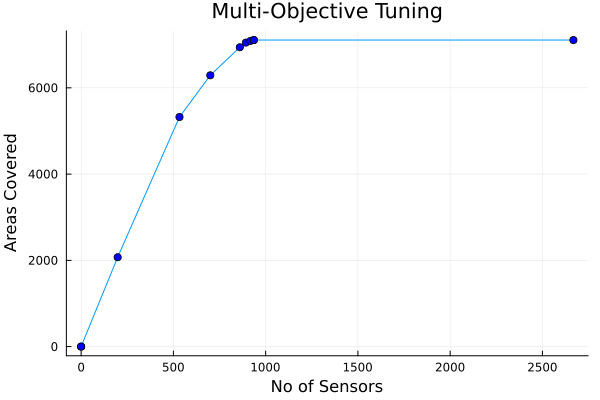

In [11]:
plot(num_sensors, num_points, xlabel="No of Sensors", ylabel="Areas Covered", title="Multi-Objective Tuning", legend=false)
scatter!(num_sensors, num_points, color=:blue, label="Different mu values") 